<a href="https://colab.research.google.com/github/butchland/fastai_nb_explorations/blob/master/fastai_scratch_with_tpu_mnist_4_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   1483      0 --:--:-- --:--:-- --:--:--  1483
Updating fastai...
Done.


In [ ]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  29406      0 --:--:-- --:--:-- --:--:-- 29406
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.1+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objec

In [ ]:
!pip freeze | grep torchvision

torchvision==0.6.0a0+3c254fb


In [ ]:
!pip install fastcore --upgrade

In [ ]:
!pip install fastai2 --upgrade

     |████████████████████████████████| 194kB 3.5MB/s 


In [ ]:
pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.61)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\ Drive/course-v4/
!pwd

/content/drive/My Drive/course-v4
/content/drive/My Drive/course-v4


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 51kB 1.8MB/s 
     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 1.1MB 4.9MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 40kB 3.9MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 2.7MB 10.9MB/s 


In [ ]:
%cd nbs

/content/drive/My Drive/course-v4/nbs


In [ ]:
!pwd

/content/drive/My Drive/course-v4/nbs


### Start of import libraries

In [ ]:
from fastai2.vision.all import *

In [ ]:
from utils import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

### Import torch xla libraries

In [ ]:
import torch

In [ ]:
import torch_xla

In [ ]:
import torch_xla.core.xla_model as xm

### Get TPU Device

In [ ]:
tpu_dev = xm.xla_device()

In [ ]:
tpu_dev

device(type='xla', index=1)

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[])


In [ ]:
dls = datablock.dataloaders(path,device=tpu_dev)

In [ ]:
xb,yb = dls.one_batch()

In [ ]:
xb.device

device(type='xla', index=1)

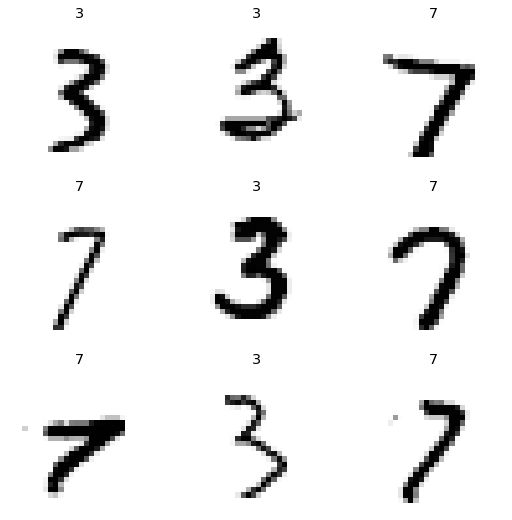

In [ ]:
dls.show_batch()

### Basic Optimizer


### Train Epoch


In [ ]:
def train_epoch(qdl,qmodel,qopt, dev):
    for xb,yb in qdl:
        calc_grad(xb.to(dev),yb.to(dev),qmodel)
        # qopt.step()
        # replace optimizer step with xla device step computation
        xm.optimizer_step(qopt, barrier=True)
        qopt.zero_grad()



### Compute Metrics


In [ ]:
def batch_accuracy(qpreds, qtargets):
    qqpreds = qpreds.sigmoid()
    correct = (qqpreds > 0.5) == qtargets
    return correct.float().mean()


In [ ]:
def validate_epoch(qmodel, qdl, dev):
    accs = [batch_accuracy(qmodel(xb.to(dev)), yb.to(dev)) for xb,yb in qdl]
    return round(torch.stack(accs).mean().item(),4)


In [ ]:
def train_model(qtrain_dl, qvalid_dl, qmodel, qopt, epochs, dev):
    for i in range(epochs):
        train_epoch(qtrain_dl, qmodel, qopt, dev)
        print(validate_epoch(qmodel, qvalid_dl, dev), end=' ')



### Build and Train Model


In [ ]:

model = nn.Linear(28*28,1).to(tpu_dev)


In [ ]:
optim = BasicOptimizer(model.parameters(),0.5)

In [ ]:

# use basic Optimizer
train_model(train_dl, valid_dl, model, optim, 50, tpu_dev)                     


0.5132 0.8247 0.9141 0.9375 0.9517 0.9624 0.9663 0.9678 0.9692 0.9712 0.9717 0.9731 0.9741 0.9761 0.9765 0.9765 0.977 0.977 0.9775 0.9785 0.979 0.979 0.9795 0.9804 0.9804 0.9804 0.9809 0.9809 0.9814 0.9814 0.9824 0.9829 0.9824 0.9824 0.9824 0.9824 0.9824 0.9829 0.9829 0.9824 0.9824 0.9824 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 

In [ ]:

train_model(train_dl, valid_dl, model, SGD(model.parameters(),0.1), 50, tpu_dev)                     

0.9824 0.9824 0.9834 0.9834 0.9834 0.9834 0.9834 0.9829 0.9829 0.9829 0.9829 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
).to(tpu_dev)

In [ ]:
sgd_optim1 = SGD(simple_net.parameters(),0.1)

In [ ]:
train_model(train_dl, valid_dl, simple_net, sgd_optim1, 50, tpu_dev)

0.5132 0.7959 0.9121 0.9404 0.9531 0.9629 0.9663 0.9668 0.9692 0.9707 0.9726 0.9741 0.9746 0.9746 0.9751 0.977 0.9775 0.978 0.978 0.978 0.9795 0.9795 0.9804 0.9804 0.9809 0.9814 0.9819 0.9819 0.9819 0.9819 0.9819 0.9829 0.9829 0.9834 0.9829 0.9829 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9824 0.9829 0.9829 0.9829 0.9829 0.9834 0.9834 0.9834 

In [ ]:
resnet18_model = resnet18(pretrained=True).to(tpu_dev)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
sgd_optim18 = SGD(resnet18_model.parameters(), 1e-2)

In [ ]:
train_model(train_dl, valid_dl, resnet18_model, sgd_optim18, 1, tpu_dev)

RuntimeError: ignored